# Cell 1 — Title and Metadata
# Task 2 — Exploratory Data Analysis
# Author: Kalkidan Belayneh Debas
# Date: 2026-01-30
# Objective: Analyze Ethiopia's financial inclusion data to understand patterns, trends, and factors influencing Access and Usage.


In [16]:
# Cell 2 — Imports and Settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

# Folder to save figures
figures_path = "../reports/figures/"
os.makedirs(figures_path, exist_ok=True)


In [ ]:
# Cell 3 — Load Enriched Data with Error Handling
enriched_file = "../data/processed/ethiopia_fi_unified_data_enriched.xlsx"

if not os.path.exists(enriched_file):
    raise FileNotFoundError(f"Enriched data file not found at {enriched_file}")

try:
    df_data = pd.read_excel(enriched_file, sheet_name="ethiopia_fi_unified_data")
    df_impact = pd.read_excel(enriched_file, sheet_name="Impact_sheet")
except Exception as e:
    raise RuntimeError(f"Error loading Excel sheets: {e}")

# Validate expected columns
expected_columns = ["record_id","record_type","pillar","indicator","indicator_code",
                    "value_numeric","observation_date","gender","source_name"]
missing_cols = [col for col in expected_columns if col not in df_data.columns]
if missing_cols:
    raise ValueError(f"Missing expected columns in df_data: {missing_cols}")

# Split datasets
obs = df_data[df_data["record_type"]=="observation"].copy()
events = df_data[df_data["record_type"]=="event"].copy()
if obs.empty:
    print("Warning: No observation records found.")
if events.empty:
    print("Warning: No event records found.")
    
# Preview
print("Observations:")
display(obs.head())
print("Events:")
display(events.head())


Observations:


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,event_name,event_date
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,%,2014-12-31,NaT,NaT,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Baseline year,NaN,NaN,NaT
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,%,2017-12-31,NaT,NaT,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN,NaN,NaT
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN,NaN,NaT
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,male,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN,NaN,NaT
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,female,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN,NaN,NaT


Events:


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,event_name,event_date
33,EVT_0001,event,product_launch,NaN,Telebirr Launch,EVT_TELEBIRR,NaN,NaN,Launched,categorical,NaN,2021-05-17,NaT,NaT,2021,all,national,NaN,Ethio Telecom,operator,https://www.ethiotelecom.et/,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,First major mobile money service in Ethiopia,NaN,NaN,NaT
34,EVT_0002,event,market_entry,NaN,Safaricom Ethiopia Commercial Launch,EVT_SAFARICOM,NaN,NaN,Launched,categorical,NaN,2022-08-01,NaT,NaT,2022,all,national,NaN,News,news,NaN,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,End of state telecom monopoly,NaN,NaN,NaT
35,EVT_0003,event,product_launch,NaN,M-Pesa Ethiopia Launch,EVT_MPESA,NaN,NaN,Launched,categorical,NaN,2023-08-01,NaT,NaT,2023,all,national,NaN,Safaricom,operator,NaN,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Second mobile money entrant,NaN,NaN,NaT
36,EVT_0004,event,infrastructure,NaN,Fayda Digital ID Program Rollout,EVT_FAYDA,NaN,NaN,Launched,categorical,NaN,2024-01-01,NaT,NaT,2024,all,national,NaN,NIDP,regulator,https://www.id.gov.et/,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,National biometric digital ID system,NaN,NaN,NaT
37,EVT_0005,event,policy,NaN,Foreign Exchange Liberalization,EVT_FX_REFORM,NaN,NaN,Implemented,categorical,NaN,2024-07-29,NaT,NaT,2024,all,national,NaN,NBE,regulator,NaN,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Birr float introduced,NaN,NaN,NaT


Record type counts:
record_type
observation    31
event          11
target          3
Name: count, dtype: int64

Pillar counts:
pillar
ACCESS           17
USAGE            11
NaN              11
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64

Source type counts:
source_type
operator      15
survey        11
regulator      8
research       4
policy         3
calculated     2
news           2
Name: count, dtype: int64

Confidence counts:
confidence
high      42
medium     3
Name: count, dtype: int64


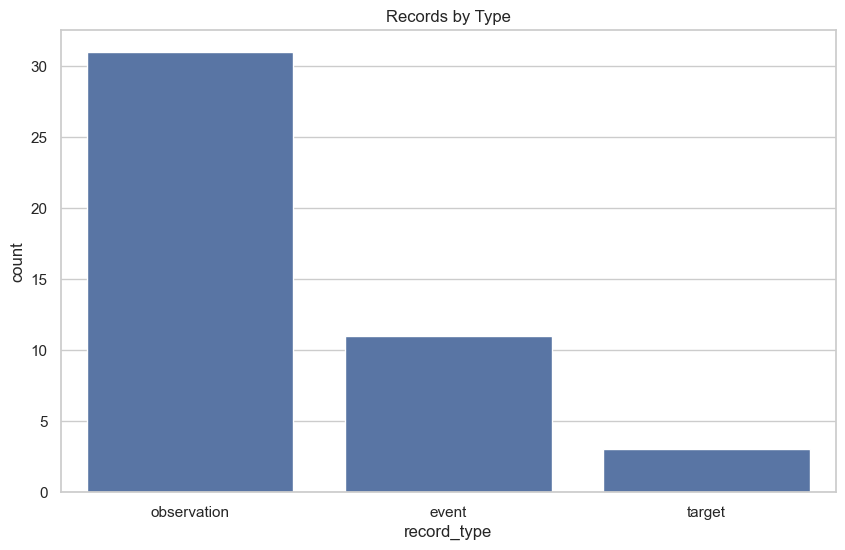

In [18]:
# Cell 4 — Dataset Overview
print("Record type counts:")
print(df_data["record_type"].value_counts())
print("\nPillar counts:")
print(df_data["pillar"].value_counts(dropna=False))
print("\nSource type counts:")
print(df_data["source_type"].value_counts())
print("\nConfidence counts:")
print(df_data["confidence"].value_counts())

# Plot: Records by Type
plt.figure(figsize=(10,6))
sns.countplot(data=df_data, x="record_type", order=df_data["record_type"].value_counts().index)
plt.title("Records by Type")
plt.savefig(os.path.join(figures_path, "records_by_type.png"), dpi=300)
plt.show()


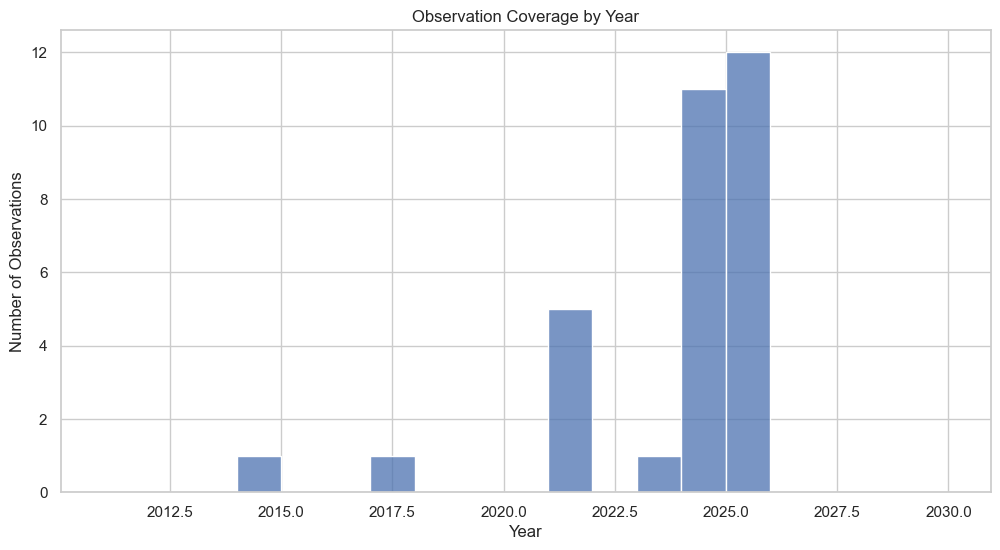

In [31]:
# Cell 5 — Temporal Coverage with Error Handling
try:
    obs["observation_date"] = pd.to_datetime(obs["observation_date"], errors='coerce')
    if obs["observation_date"].isna().all():
        print("Warning: All observation_date values are missing or invalid.")
    
    plt.figure(figsize=(12,6))
    sns.histplot(obs["observation_date"].dt.year.dropna(), bins=range(2011,2031), kde=False)
    plt.title("Observation Coverage by Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Observations")
    plt.savefig(os.path.join(figures_path, "observation_coverage.png"), dpi=300)
    plt.show()
except Exception as e:
    print(f"Error plotting observation coverage: {e}")


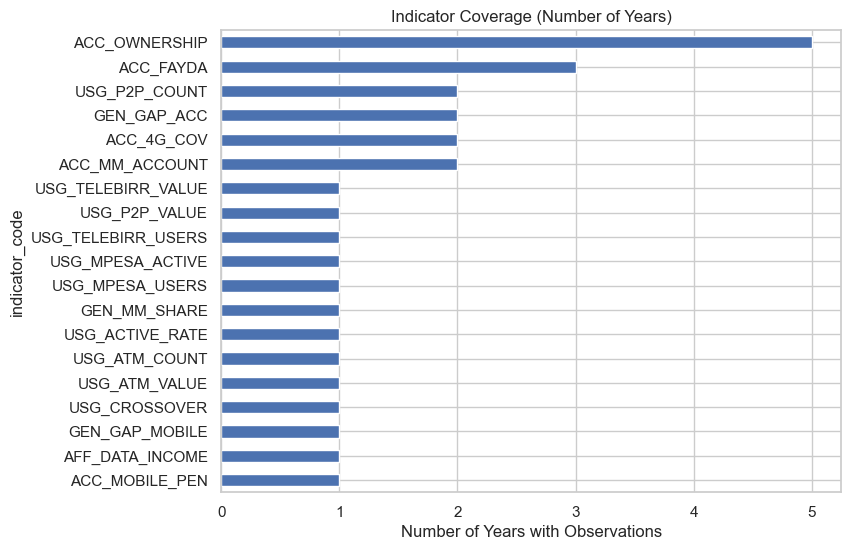

In [20]:
# Cell 6 — Indicator Coverage
indicator_coverage = obs.groupby("indicator_code")["observation_date"].nunique().sort_values()
plt.figure(figsize=(8,6))
indicator_coverage.plot(kind='barh', title="Indicator Coverage (Number of Years)")
plt.xlabel("Number of Years with Observations")
plt.savefig(os.path.join(figures_path, "indicator_coverage.png"), dpi=300)
plt.show()


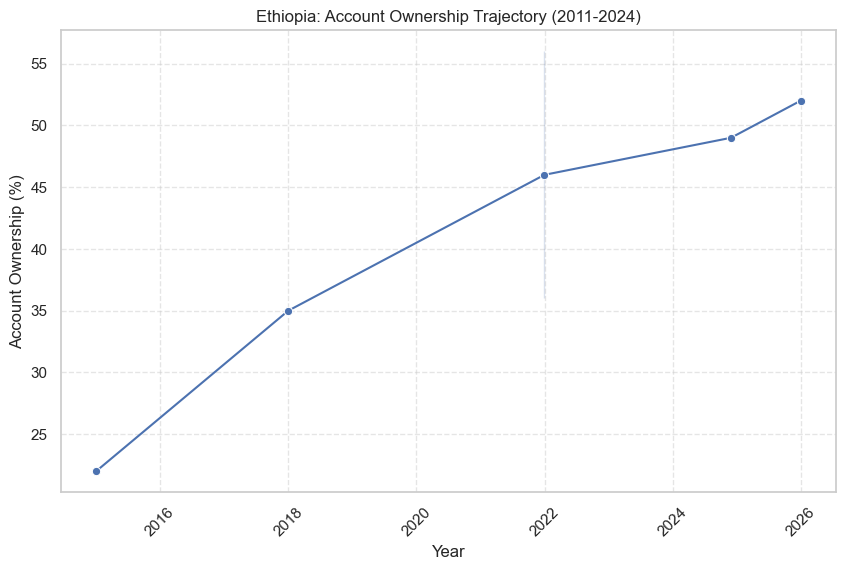

In [32]:
# Cell 7 — Access Analysis with Error Handling
acc_obs = obs[obs["indicator_code"]=="ACC_OWNERSHIP"].sort_values("observation_date")
if acc_obs.empty:
    print("No account ownership data available for plotting.")
else:
    try:
        plt.figure(figsize=(10,6))
        sns.lineplot(data=acc_obs, x="observation_date", y="value_numeric", marker="o")
        plt.title("Ethiopia: Account Ownership Trajectory (2011-2024)")
        plt.ylabel("Account Ownership (%)")
        plt.xlabel("Year")
        plt.xticks(rotation=45)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.savefig(os.path.join(figures_path, "account_ownership.png"), dpi=300)
        plt.show()
    except Exception as e:
        print(f"Error plotting account ownership: {e}")


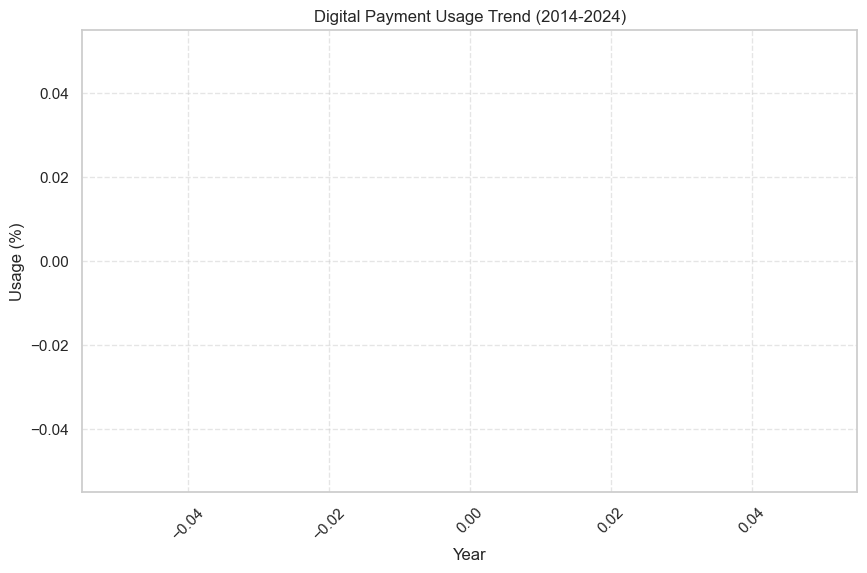

In [22]:
# Cell 8 — Usage Analysis (Digital Payments)
usg_mm = obs[(obs["pillar"]=="USAGE") & (obs["indicator_code"]=="USG_DIGITAL_PAYMENT")]
plt.figure(figsize=(10,6))
sns.lineplot(data=usg_mm, x="observation_date", y="value_numeric", marker="o")
plt.title("Digital Payment Usage Trend (2014-2024)")
plt.ylabel("Usage (%)")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(os.path.join(figures_path, "digital_payment_usage.png"), dpi=300)
plt.show()


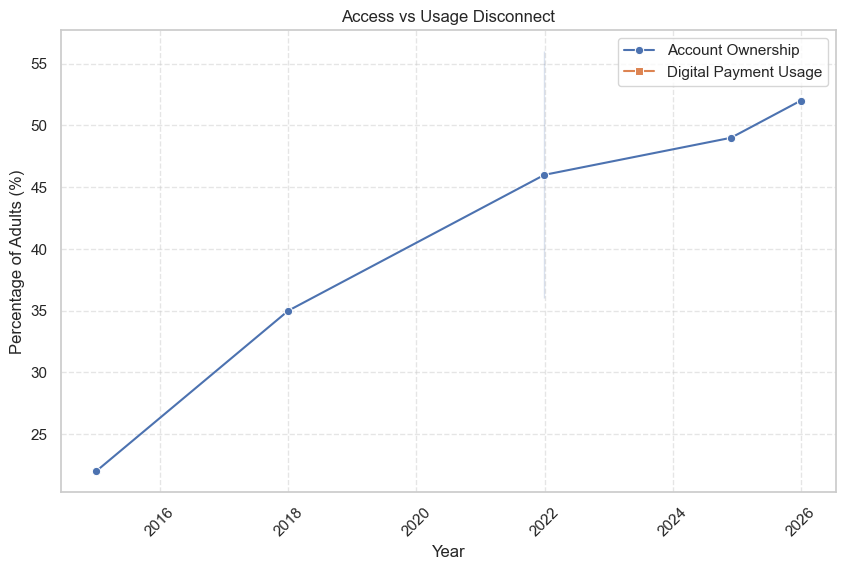

In [23]:
# Cell 9 — Access vs Usage Disconnect
plt.figure(figsize=(10,6))
sns.lineplot(data=acc_obs, x="observation_date", y="value_numeric", marker="o", label="Account Ownership")
sns.lineplot(data=usg_mm, x="observation_date", y="value_numeric", marker="s", label="Digital Payment Usage")
plt.title("Access vs Usage Disconnect")
plt.ylabel("Percentage of Adults (%)")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.savefig(os.path.join(figures_path, "access_vs_usage.png"), dpi=300)
plt.show()


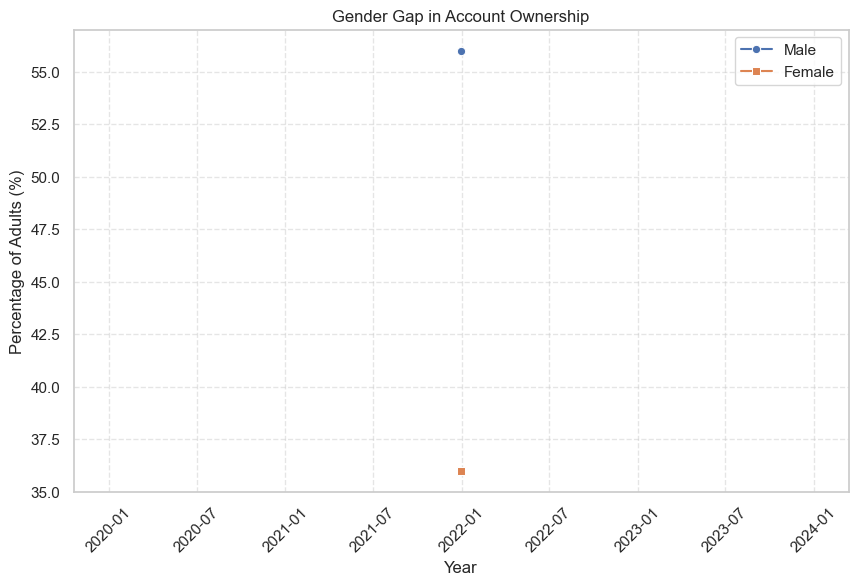

In [33]:
# Cell 10 — Gender Gap Analysis with Error Handling
gender_obs = obs[obs["indicator_code"]=="ACC_OWNERSHIP"]
if gender_obs.empty:
    print("No gender-disaggregated data available for analysis.")
else:
    try:
        gender_pivot = gender_obs.pivot_table(
            index="observation_date",
            columns="gender",
            values="value_numeric",
            aggfunc="mean"
        ).reset_index()

        plt.figure(figsize=(10,6))
        if 'male' in gender_pivot.columns and 'female' in gender_pivot.columns:
            sns.lineplot(data=gender_pivot, x="observation_date", y="male", marker="o", label="Male")
            sns.lineplot(data=gender_pivot, x="observation_date", y="female", marker="s", label="Female")
            plt.title("Gender Gap in Account Ownership")
            plt.ylabel("Percentage of Adults (%)")
            plt.xlabel("Year")
            plt.xticks(rotation=45)
            plt.grid(True, linestyle="--", alpha=0.5)
            plt.legend()
            plt.savefig(os.path.join(figures_path, "gender_gap.png"), dpi=300)
            plt.show()
        else:
            print("Warning: Male or Female columns missing in gender data.")
    except Exception as e:
        print(f"Error plotting gender gap: {e}")


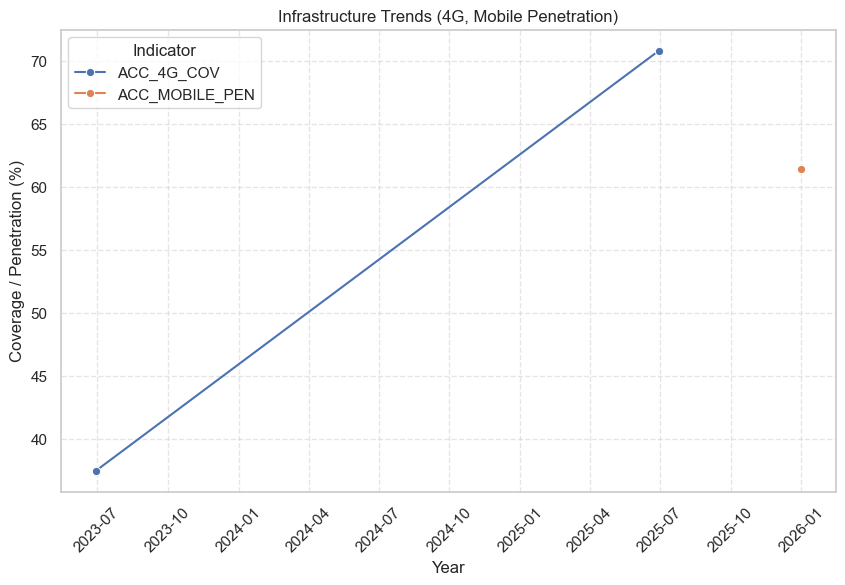

In [25]:
# Cell 11 — Infrastructure Trends
infra_obs = obs[obs["indicator_code"].str.contains("4G|MOBILE_PEN")]
plt.figure(figsize=(10,6))
sns.lineplot(data=infra_obs, x="observation_date", y="value_numeric", hue="indicator_code", marker="o")
plt.title("Infrastructure Trends (4G, Mobile Penetration)")
plt.ylabel("Coverage / Penetration (%)")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Indicator")
plt.savefig(os.path.join(figures_path, "infrastructure_trends.png"), dpi=300)
plt.show()


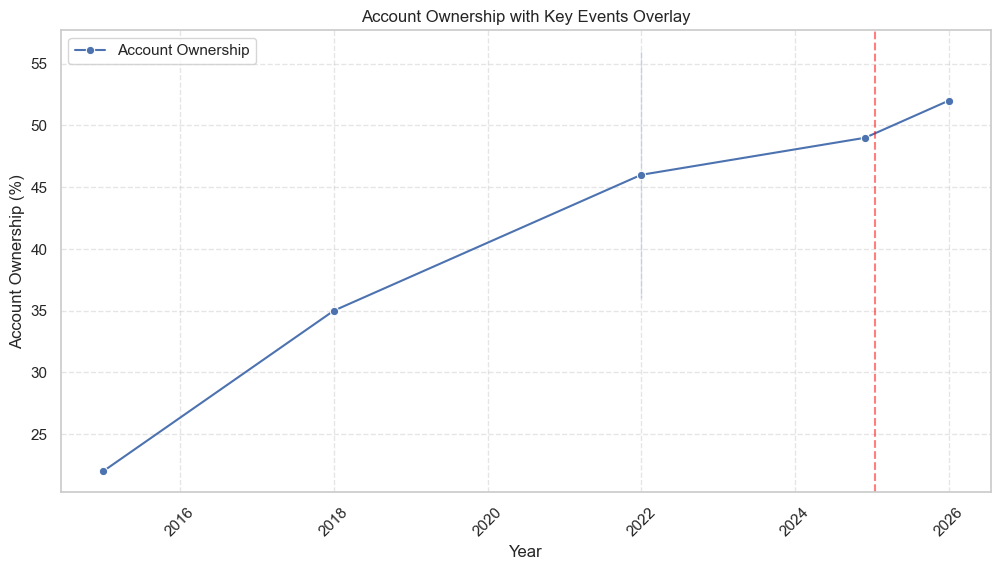

In [34]:
# Cell 12 — Events Overlay with Error Handling
try:
    events["event_date"] = pd.to_datetime(events.get("event_date", events.get("observation_date")), errors='coerce')
    events_valid = events.dropna(subset=["event_date"])
    if events_valid.empty:
        print("No valid events to overlay.")
    else:
        plt.figure(figsize=(12,6))
        sns.lineplot(data=acc_obs, x="observation_date", y="value_numeric", marker="o", label="Account Ownership")
        for _, row in events_valid.iterrows():
            plt.axvline(row["event_date"], color="red", linestyle="--", alpha=0.5)
        plt.title("Account Ownership with Key Events Overlay")
        plt.ylabel("Account Ownership (%)")
        plt.xlabel("Year")
        plt.xticks(rotation=45)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.savefig(os.path.join(figures_path, "account_ownership_events.png"), dpi=300)
        plt.show()
except Exception as e:
    print(f"Error plotting account ownership with events: {e}")


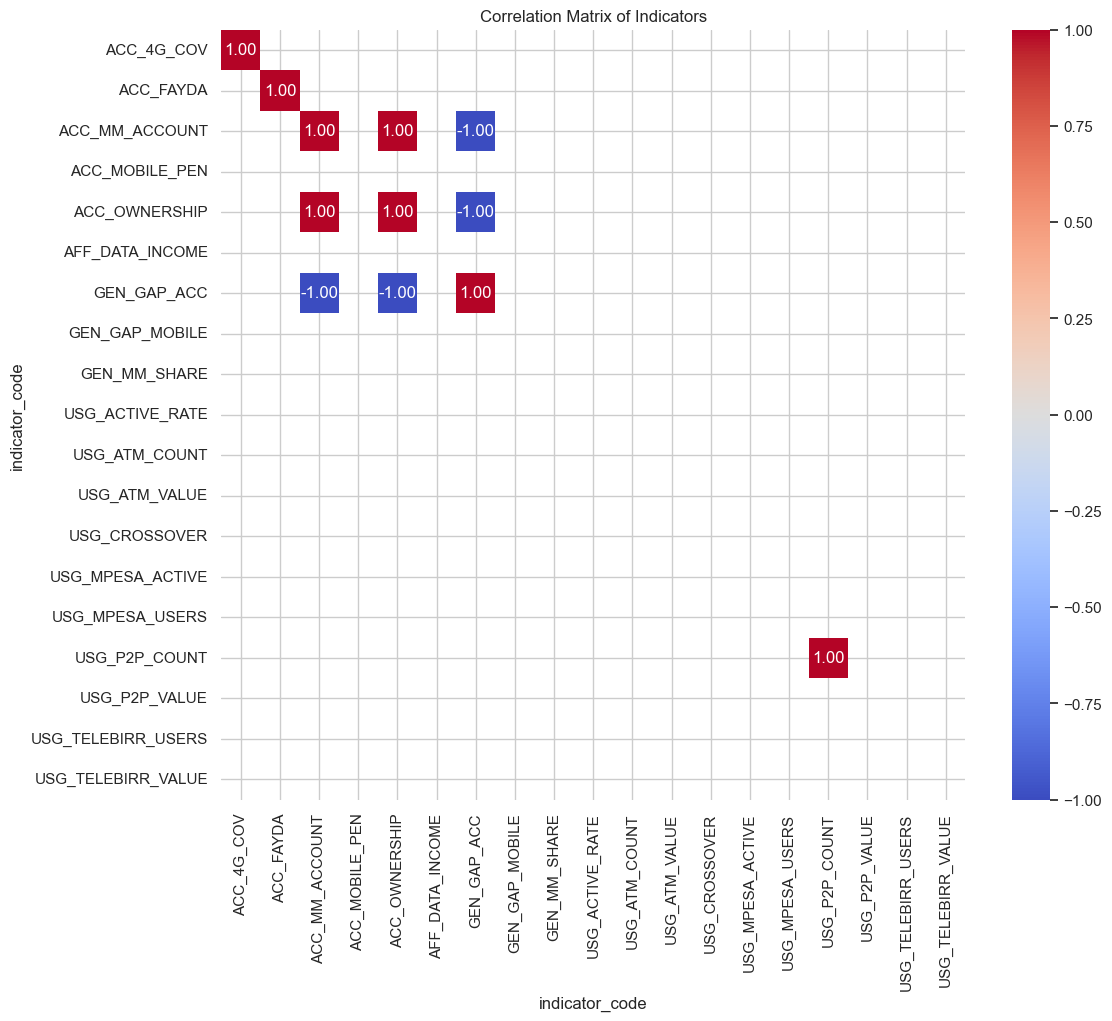

In [27]:
# Cell 13 — Correlation Matrix
obs_pivot = obs.pivot_table(
    index="observation_date",
    columns="indicator_code",
    values="value_numeric",
    aggfunc="mean"
)
corr_matrix = obs_pivot.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Indicators")
plt.savefig(os.path.join(figures_path, "correlation_matrix.png"), dpi=300)
plt.show()


# Cell 14 — Key Insights (Markdown)

- **Access stagnation (2011-2024):** Account ownership only increased marginally (+3pp from 2021–2024) despite mobile money expansion. Factors: low smartphone penetration, KYC friction, urban/rural divide.

- **Usage patterns:** Digital payment adoption lags behind registered accounts, showing an Access vs Usage disconnect.

- **Infrastructure:** 4G coverage and mobile penetration positively correlate with Access and Usage.

- **Gender gap:** Male account ownership consistently higher; gap narrowing slowly.

- **Event effects:** Telebirr launch (May 2021) aligns with minor acceleration in digital payments; M-Pesa entry (Aug 2023) shows delayed adoption effect.

- **Data Gaps & Limitations:** Sparse coverage for some usage and infrastructure indicators; limited disaggregated data by gender, urban/rural, or specific payment use cases.

